# Project: Sentiment analysis using Amazon reviews

### Author: Younes Bensassi-Nour
### Dataset:  https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

    

This work is a contribution and part of a team work for sentiment analysis using Amazon reviews data.  
We focused on applying roBERTa pretrained model, but other algorithms were used like LSTM.  

We select a reduced volume of data: 30000 balanced samples

#### Development platform:  
Kaggle

#### Model:  
roberta-base for text classification  

#### Hyperparameters:    
Number of Epochs = 16  
Learning rate = 1e-6  
Batch size = 16   
Tokenizer maximum length = 128  

#### Results:  
Training loss: 0.4459 - Training accuracy: 0.8211   
Validation loss: 0.5495 - Validation accuracy: 0.7763  
Test loss: 0.5526 - Test accuracy: 0.7724  

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/reviewsbalanced-reduced-30k/ReviewsBalanced_reduced_30k.csv')

# Display the first few rows of the CSV file
df.head()


,Score,label,text
0,2,0,i bought this to feed a few feral cats they ab...
1,5,2,loved it i didnt have an airbrush so i just sh...
2,4,2,let me start by saying that i am not a sweet p...
3,4,2,i first saw this shampoo at walmart i was a li...
4,2,0,i am glad for the chestnut growers that the be...


In [2]:
df.columns

Index(['Score', 'label', 'text'], dtype='object')

In [3]:
df.shape

(29989, 3)

In [4]:
df_clean = df.drop(columns=["Score"])

In [5]:
df_clean.head()

,label,text
0,0,i bought this to feed a few feral cats they ab...
1,2,loved it i didnt have an airbrush so i just sh...
2,2,let me start by saying that i am not a sweet p...
3,2,i first saw this shampoo at walmart i was a li...
4,0,i am glad for the chestnut growers that the be...


In [6]:
from sklearn.model_selection import train_test_split

# Split into training and temp (which will be split into validation and test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.3, random_state=42
)

# Split temp into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Testing samples: {len(test_texts)}")

Training samples: 20992
Validation samples: 4498
Testing samples: 4499


In [7]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
# Load the pre-trained model from Hugging Face
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [10]:
# # Tokenize function
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

In [11]:
# Tokenize the data
train_encodings = tokenize_texts(train_texts, tokenizer)
val_encodings = tokenize_texts(val_texts, tokenizer)
test_encodings = tokenize_texts(test_texts, tokenizer)

In [12]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))


In [13]:
# Batch the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [14]:
# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=0.1) #, clipvalue=1.0
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # We have 3 labels (Positive, Neutral, Negative = 2, 1, 0)
metrics = tf.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metrics])

In [16]:
# Define model checkpoint to save only the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    #save_format='tf'
)

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),

    # Updated ModelCheckpoint to save in TensorFlow format
    tf.keras.callbacks.ModelCheckpoint(
        'best_model',  # Saves the model in TensorFlow's native format
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_format='tf'  # Save in TensorFlow's format (not HDF5)
    )
]


In [18]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1727201207.862285     113 service.cc:145] XLA service 0x7d8775c41ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727201207.862336     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727201208.102996     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1312/1312 [==============================] - ETA: 0s - loss: 0.7925 - accuracy: 0.6256

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


1312/1312 [==============================] - 501s 306ms/step - loss: 0.7925 - accuracy: 0.6256 - val_loss: 0.5901 - val_accuracy: 0.7490
Epoch 2/10
1312/1312 [==============================] - 382s 291ms/step - loss: 0.5737 - accuracy: 0.7591 - val_loss: 0.5515 - val_accuracy: 0.7681
Epoch 3/10
1312/1312 [==============================] - 382s 291ms/step - loss: 0.5396 - accuracy: 0.7742 - val_loss: 0.5463 - val_accuracy: 0.7683
Epoch 4/10
1312/1312 [==============================] - 375s 286ms/step - loss: 0.5164 - accuracy: 0.7880 - val_loss: 0.5481 - val_accuracy: 0.7717
Epoch 5/10
1312/1312 [==============================] - 381s 291ms/step - loss: 0.4983 - accuracy: 0.7955 - val_loss: 0.5360 - val_accuracy: 0.7766
Epoch 6/10
1312/1312 [==============================] - 375s 286ms/step - loss: 0.4753 - accuracy: 0.8065 - val_loss: 0.5424 - val_accuracy: 0.7772
Epoch 7/10
1312/1312 [==============================] - 374s 285ms/step - loss: 0.4648 - accuracy: 0.8102 - val_loss: 0.540

In [19]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")


282/282 [==============================] - 27s 96ms/step - loss: 0.5526 - accuracy: 0.7724
Test Accuracy: 0.7723938822746277


In [20]:
# Save the model
model.save("my_model_30k")

In [21]:
# Plot training & validation loss and accuracy
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

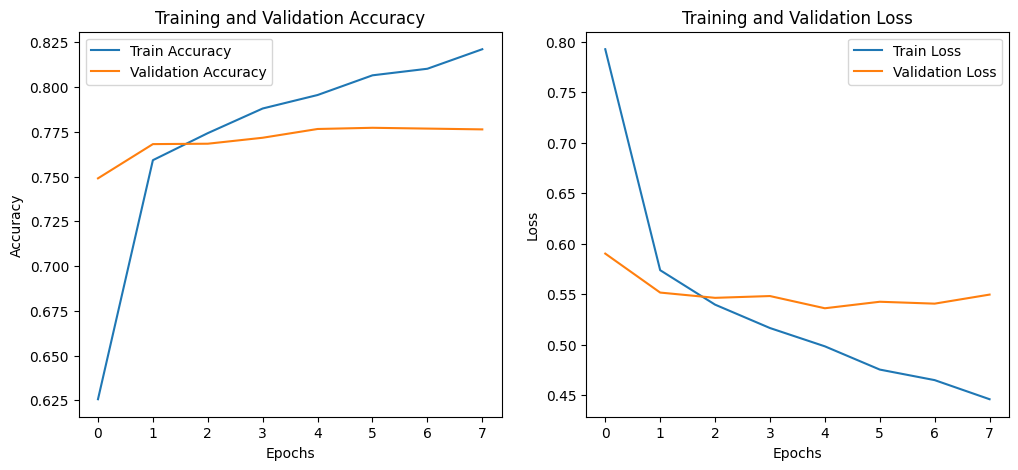

In [22]:
# Plot training history
plot_history(history)

We still have an overfitting even though we achieved 77.24% accuracy on the Test dataset  

We can improve that by modifying Hyperparameters or implement transfer learning